In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import root_pandas as rp
import ROOT
import array
from scipy.optimize import curve_fit

tpcs = ['iiwi', 'nene', 'humu', 'palila', 'tako', 'elepaio']
after_threshold_He = {}
before_drift_He = {}
after_drift_He = {}

for tpc in tpcs:
    after_threshold_He[tpc] = rp.read_root("~/data/phase3/simulation/resolution_paper/tpc_sims/%s_after_threshold_He_all.root"%(tpc))
    before_drift_He[tpc] = rp.read_root("~/data/phase3/simulation/resolution_paper/tpc_sims/%s_before_drift_He_all.root"%(tpc))
    after_drift_He[tpc] = rp.read_root("~/data/phase3/simulation/resolution_paper/tpc_sims/%s_after_drift_He_all.root"%(tpc))

## Input gain, ToT values, and sumQ from ToT. Also add truth z

In [35]:
gain = {'iiwi': 1502, 'nene': 899, 'humu': 878, 'palila': 1033, 'tako': 807, 'elepaio': 797}
W = 35.075
tot_to_q = {}
for tpc in tpcs:
    tot_to_q[tpc] = pd.DataFrame()
    tot_to_q[tpc]['tot_code'] = [i for i in range(0,14)]

tot_to_q['iiwi']['conversion'] = [1833.00, 2345.17, 3017.33, 6001.54, 8891.71,
                                  11497.43, 14335.32, 18081.33, 22526.06, 27236.90,
                                  32056.16, 36955.09, 41874.75, 46794.40]

tot_to_q['nene']['conversion'] = [1085.31, 2482.24, 4126.52, 5621.03, 7920.43,
                                  11667.35, 15117.97, 19489.23, 23211.63, 27483.98,
                                  32272.73, 37262.83, 42283.59, 47304.34]

tot_to_q['humu']['conversion'] = [1758.29, 2324.41, 3679.37, 5433.43, 6862.72,
                                  10000.83, 13701.08, 17258.86, 21438.70, 25821.34,
                                  30153.82, 34460.74, 39042.80, 43624.85]

tot_to_q['palila']['conversion'] = [1768.71, 2202.75, 2670.76, 4049.25, 6586.25,
                                    8954.45, 11551.60, 14428.46, 17618.81, 21140.34,
                                    24831.56, 28804.80, 33534.23, 40821.35]

tot_to_q['tako']['conversion'] = [2761.20, 3077.66, 3509.80, 5475.02, 9230.59, 
                                  11955.00, 16837.46, 20761.78, 24514.73, 28445.96, 
                                  33071.27, 38033.29, 43011.21, 47989.15]

tot_to_q['elepaio']['conversion'] = [1859.09, 2496.61, 4128.03, 6844.95, 9450.70,
                                     12158.68, 15125.31, 18507.89, 22166.14, 25826.40,
                                     29597.06, 33588.70, 38207.92, 42827.15]

for tpc in tpcs:
    after_threshold_He[tpc]['q_from_tot'] = after_threshold_He[tpc]['tot']
    for i in range(0,len(after_threshold_He[tpc])):
        after_threshold_He[tpc]['q_from_tot'].iloc[i] = pd.Series(after_threshold_He[tpc].iloc[i]['tot']).map(tot_to_q[tpc].set_index('tot_code')['conversion']).to_numpy()
    after_threshold_He[tpc]['sumtot'] = [after_threshold_He[tpc]['q_from_tot'][i].sum() for i in range(0,len(after_threshold_He[tpc]))]
    
    #Add truth z
    after_threshold_He[tpc]['truth_z'] = [after_threshold_He[tpc]['truth_center'].iloc[i][2] for i in range(0,len(after_threshold_He[tpc]))]
    after_drift_He[tpc]['truth_z'] = [after_drift_He[tpc]['truth_center'].iloc[i][2] for i in range(0,len(after_drift_He[tpc]))]
    before_drift_He[tpc]['truth_z'] = [before_drift_He[tpc]['truth_center'].iloc[i][2] for i in range(0,len(before_drift_He[tpc]))]


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Add tighter truth z fiducial cuts

In [36]:
zmin = 2
zmax = 8
for tpc in tpcs:
    after_threshold_He[tpc] = after_threshold_He[tpc].loc[(after_threshold_He[tpc]['truth_z'] > zmin) & (after_threshold_He[tpc]['truth_z'] < zmax)]
    after_drift_He[tpc] = after_drift_He[tpc].loc[(after_drift_He[tpc]['truth_z'] > zmin) & (after_drift_He[tpc]['truth_z'] < zmax)]
    before_drift_He[tpc] = before_drift_He[tpc].loc[(before_drift_He[tpc]['truth_z'] > zmin) & (before_drift_He[tpc]['truth_z'] < zmax)]
    after_threshold_He[tpc].index = [i for i in range(0,len(after_threshold_He[tpc]))]
    after_drift_He[tpc].index = [i for i in range(0,len(after_drift_He[tpc]))]
    before_drift_He[tpc].index = [i for i in range(0,len(before_drift_He[tpc]))]

### Group data by truth_energy

In [37]:
before_drift_He_group = {}
after_drift_He_group = {}
after_thresh_group = {}
for tpc in tpcs:
    before_drift_He_group[tpc] = before_drift_He[tpc].groupby(['truth_energy'])
    after_drift_He_group[tpc] = after_drift_He[tpc].groupby(['truth_energy'])
    after_thresh_group[tpc] = after_threshold_He[tpc].groupby(['truth_energy'])

### Plot reconstructed energy/truth energy distributions

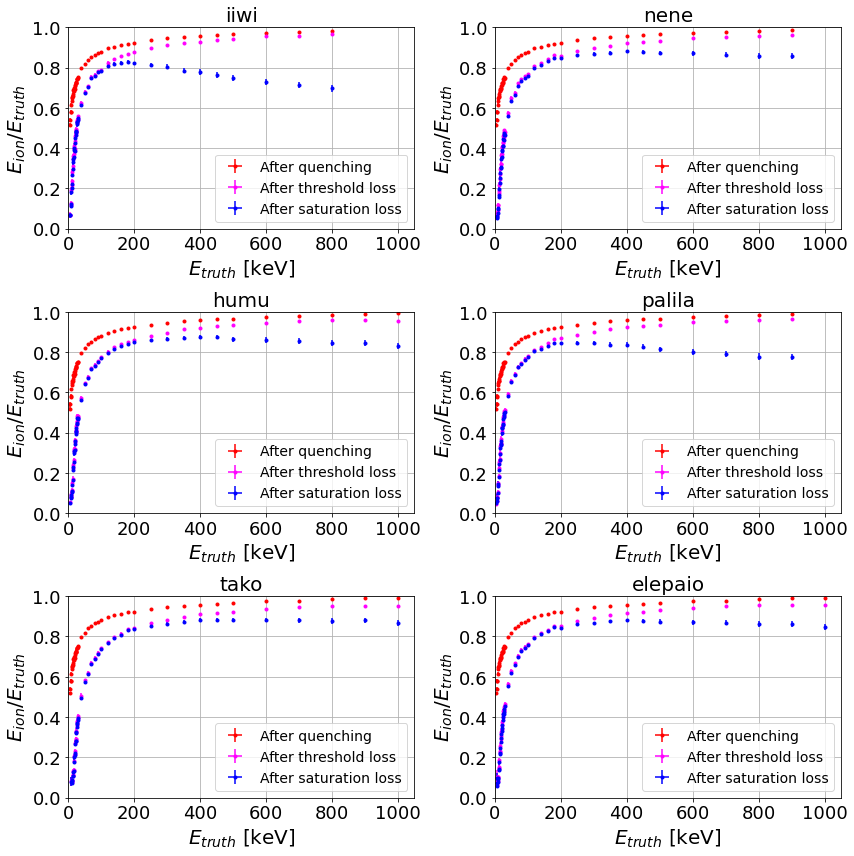

In [38]:
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
plt.figure(figsize = (12,12))
x_plt = np.linspace(-10,110,121)
i = 1
for tpc in tpcs:
    plt.subplot(3,2,i)
    plt.errorbar(after_drift_He_group[tpc].mean().index,
                 after_drift_He_group[tpc].mean()['truth_charge']*35.075*1e-03/after_drift_He_group[tpc].mean().index,
                 after_drift_He_group[tpc].sem()['truth_charge']*35.075*1e-03/after_drift_He_group[tpc].mean().index,
                 [0 for i in range(0,len(after_drift_He_group[tpc].mean()))],
                 'o',markersize = 3, label = r'After quenching', color = 'red')
    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].mean()['qsum']*35.075*1e-03/gain[tpc])/after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].sem()['qsum']*35.075*1e-03/gain[tpc])/after_thresh_group[tpc].mean().index,
                 [0 for i in range(0,len(after_thresh_group[tpc].mean()))],
                 'o',markersize = 3, label = r'After threshold loss', color = 'magenta')
    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].mean()['sumtot']*35.075*1e-03/gain[tpc])/after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].sem()['sumtot']*35.075*1e-03/gain[tpc])/after_thresh_group[tpc].mean().index,
                 [0 for i in range(0,len(after_thresh_group[tpc].mean()))],
                 'o',markersize = 3, label = r'After saturation loss', color = 'blue')
    plt.ylabel(r'$E_{ion}/E_{truth}$')
    plt.xlabel(r'$E_{truth}$ [keV]')
    plt.ylim(0,1)
    plt.xlim(0,1050)
    plt.legend(loc ='lower right')
    plt.grid()
    plt.title(tpc)
    i += 1
plt.tight_layout()
plt.show()

### Determine RMS reconstructed energy and corresponding uncertainy

In [39]:
h_thresh_sat = {}
h_thresh = {}
h_quench = {}
vals_thresh_sat = {}
vals_thresh = {}
vals_quench = {}
rms_errors_quench = {}
rms_errors_thresh = {}
rms_errors_thresh_sat = {}

for tpc in tpcs:
    rms_errors_quench[tpc] = []
    rms_errors_thresh[tpc] = []
    rms_errors_thresh_sat[tpc] = []
    for energy in after_drift_He[tpc]['truth_energy'].unique(): #quenching loop
        h_quench[tpc+'_'+str(energy)] = ROOT.TH1F('%s_%s'%(tpc,energy), '%s_%s'%(tpc,energy), 21, 0, 100)
        vals_quench[tpc+'_'+str(energy)] = array.array('d', after_thresh_group[tpc].mean().loc[after_threshold_He[tpc]['truth_energy'] == energy]['truth_charge']*W*1e-03)
        for i in range(0,len(vals_quench[tpc+'_'+str(energy)])):
            h_quench[tpc+'_'+str(energy)].Fill(vals_quench[tpc+'_'+str(energy)][i])
        rms_errors_quench[tpc].append(h_quench[tpc+'_'+str(energy)].GetRMSError())
    for energy in after_threshold_He[tpc]['truth_energy'].unique(): #thresh and saturation
        h_thresh_sat[tpc+'_'+str(energy)] = ROOT.TH1F('%s_%s'%(tpc,energy), '%s_%s'%(tpc,energy), 21, 0, 100)
        h_thresh[tpc+'_'+str(energy)] = ROOT.TH1F('%s_%s'%(tpc,energy), '%s_%s'%(tpc,energy), 21, 0, 100)
        vals_thresh_sat[tpc+'_'+str(energy)] = array.array('d', after_thresh_group[tpc].mean().loc[after_threshold_He[tpc]['truth_energy'] == energy]['sumtot']*W*1e-03/gain[tpc])
        vals_thresh[tpc+'_'+str(energy)] = array.array('d', after_thresh_group[tpc].mean().loc[after_threshold_He[tpc]['truth_energy'] == energy]['qsum']*W*1e-03/gain[tpc])
        for i in range(0,len(vals_thresh_sat[tpc+'_'+str(energy)])):
            h_thresh_sat[tpc+'_'+str(energy)].Fill(vals_thresh_sat[tpc+'_'+str(energy)][i])
        for i in range(0,len(vals_thresh[tpc+'_'+str(energy)])):
            h_thresh[tpc+'_'+str(energy)].Fill(vals_thresh[tpc+'_'+str(energy)][i])
        rms_errors_thresh_sat[tpc].append(h_thresh_sat[tpc+'_'+str(energy)].GetRMSError())
        rms_errors_thresh[tpc].append(h_thresh[tpc+'_'+str(energy)].GetRMSError())
    rms_errors_thresh_sat[tpc] = np.array(rms_errors_thresh_sat[tpc])
    rms_errors_thresh[tpc] = np.array(rms_errors_thresh[tpc])
    rms_errors_quench[tpc] = np.array(rms_errors_quench[tpc])

Warning in <TROOT::Append>: Replacing existing TH1: iiwi_100.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_10.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_11.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_120.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_12.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_13.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_140.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_14.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_15.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_160.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_16.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing e

### Plot energy resolutions

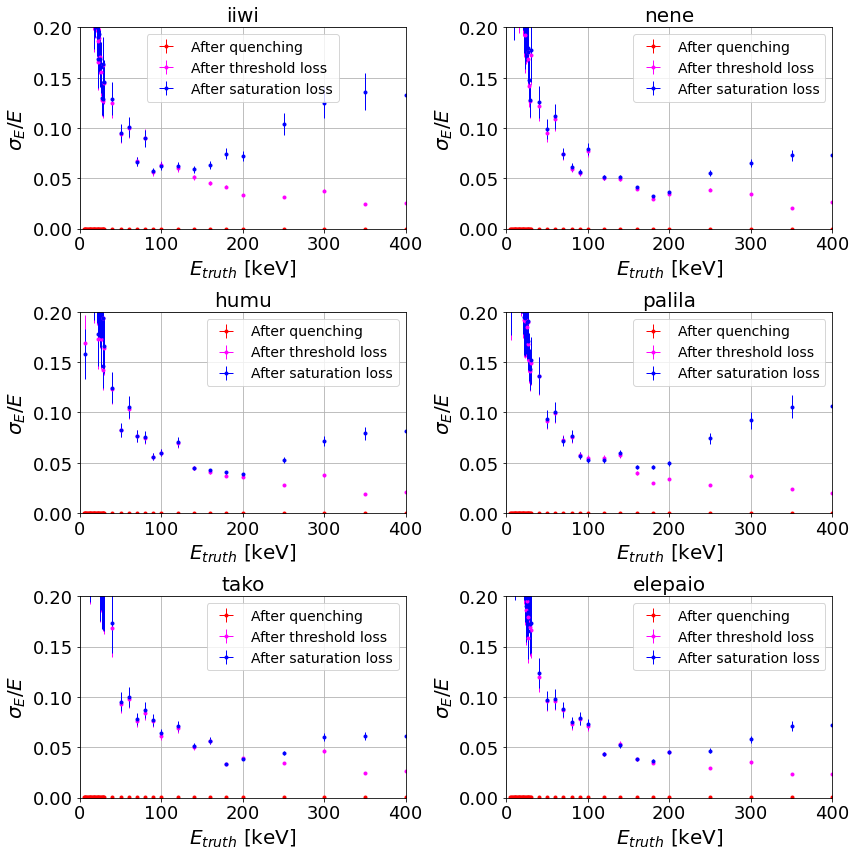

In [41]:
reso_errors_thresh_sat = {}
reso_errors_thresh = {}
reso_errors_quench = {}
for tpc in tpcs:
    reso_errors_quench[tpc] = after_drift_He_group[tpc].std()['truth_charge']*35.075*1e-03/after_drift_He_group[tpc].mean()['truth_charge']*35.075*1e-03 * np.sqrt((rms_errors_quench[tpc]/after_drift_He_group[tpc].std()['truth_charge']*35.075*1e-03)**2 + (after_drift_He_group[tpc].std()['truth_charge']*35.075*1e-03/after_drift_He_group[tpc].mean()['truth_charge']*35.075*1e-03)**2)
    reso_errors_thresh[tpc] = (after_thresh_group[tpc].std()['qsum']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['qsum']*35.075*1e-03/gain[tpc]) * np.sqrt((rms_errors_thresh[tpc]/(after_thresh_group[tpc].std()['qsum']*35.075*1e-03)/gain[tpc])**2 + ((after_thresh_group[tpc].std()['qsum']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['qsum']*35.075*1e-03/gain[tpc]))**2)
    reso_errors_thresh_sat[tpc] = (after_thresh_group[tpc].std()['sumtot']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['sumtot']*35.075*1e-03/gain[tpc]) * np.sqrt((rms_errors_thresh_sat[tpc]/(after_thresh_group[tpc].std()['sumtot']*35.075*1e-03)/gain[tpc])**2 + ((after_thresh_group[tpc].std()['sumtot']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['sumtot']*35.075*1e-03/gain[tpc]))**2)

plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
plt.figure(figsize = (12,12))
x_plt = np.linspace(-10,110,121)
i = 1
for tpc in tpcs:
    plt.subplot(3,2,i)
    plt.errorbar(after_drift_He_group[tpc].mean().index,
                 after_drift_He_group[tpc].std()['truth_charge']*35.075*1e-03/after_drift_He_group[tpc].mean()['truth_charge']*35.075*1e-03,
                 reso_errors_quench[tpc], [0 for i in range(0,len(reso_errors_quench[tpc]))],
                 'o',markersize = 3, label = r'After quenching', color = 'red', lw = 1)
    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].std()['qsum']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['qsum']*35.075*1e-03/gain[tpc]),
                 reso_errors_thresh[tpc], [0 for i in range(0,len(reso_errors_thresh[tpc]))],
                 'o',markersize = 3, label = r'After threshold loss', color = 'magenta', lw = 1)
    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].std()['sumtot']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['sumtot']*35.075*1e-03/gain[tpc]),
                 reso_errors_thresh_sat[tpc], [0 for i in range(0,len(reso_errors_thresh_sat[tpc]))],
                 'o',markersize = 3, label = r'After saturation loss', color = 'blue', lw = 1)
    plt.xlabel(r'$E_{truth}$ [keV]')
    plt.ylabel(r'$\sigma_E/E$')
    plt.xlim(0,400)
    plt.ylim(0,0.2)
    plt.title(tpc)
    plt.grid()
    plt.legend()
    i += 1
plt.tight_layout()
plt.show()

## Add saturation fraction and mean ToT per event

In [8]:
def get_saturation_fraction(dataframe):
    saturation_fraction = []
    for i in range(0,len(dataframe)):
        saturation_fraction.append(len([val for val in dataframe['tot'].iloc[i] if val == 13])/len(dataframe['tot'].iloc[i]))
    dataframe['saturation_fraction'] = saturation_fraction
    return dataframe
def get_mean_tot(dataframe):
    tot_mean = []
    for i in range(0,len(dataframe)):
        tot_mean.append(dataframe['tot'].iloc[i].mean())
    dataframe['mean_tot'] = tot_mean
    return dataframe
for tpc in tpcs:
    after_threshold_He[tpc] = get_saturation_fraction(after_threshold_He[tpc])
    after_threshold_He[tpc] = get_mean_tot(after_threshold_He[tpc])

In [14]:
sat_frac_group = {}
mean_tot_group = {}
for tpc in tpcs:
    sat_frac_group[tpc] = after_threshold_He[tpc].groupby(pd.cut(after_threshold_He[tpc]['saturation_fraction'], bins = np.linspace(0.0,0.5,21)))

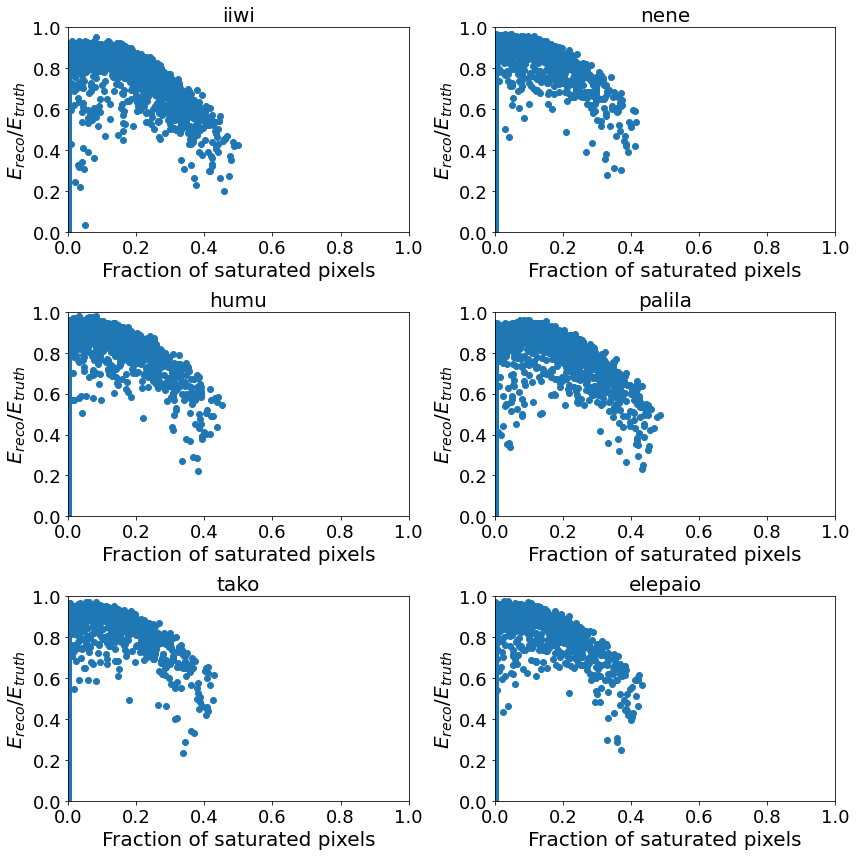

In [15]:
plt.figure(figsize = (12,12))
i = 1
for tpc in tpcs:
    plt.subplot(3,2,i)
    after_threshold_He[tpc]['reco_energy'] = after_threshold_He[tpc]['sumtot']*35.075/gain[tpc]*1e-3
    plt.plot(after_threshold_He[tpc]['saturation_fraction'], after_threshold_He[tpc]['reco_energy']/after_threshold_He[tpc]['truth_energy'],'o')
    plt.xlabel('Fraction of saturated pixels')
    plt.ylabel(r'$E_{reco}/E_{truth}$')
    plt.title(tpc)
    plt.xlim(0.0,1)
    plt.ylim(0,1)
    i += 1
plt.tight_layout()
plt.show()

### Plot fit polynomials to saturation correction

iiwi [ 8.28075054 -9.25072275  1.73337641  0.77100056]
nene [ 2.76820777 -4.62201532  0.38792681  0.90654904]
humu [ 5.37370598 -5.94117861  0.63143566  0.90079916]
palila [ 7.10494366 -7.99270095  1.38003269  0.83088408]
tako [ 1.72015106 -4.27810885  0.49626732  0.89819657]
elepaio [ 2.51163265 -4.78875537  0.58116946  0.89233023]


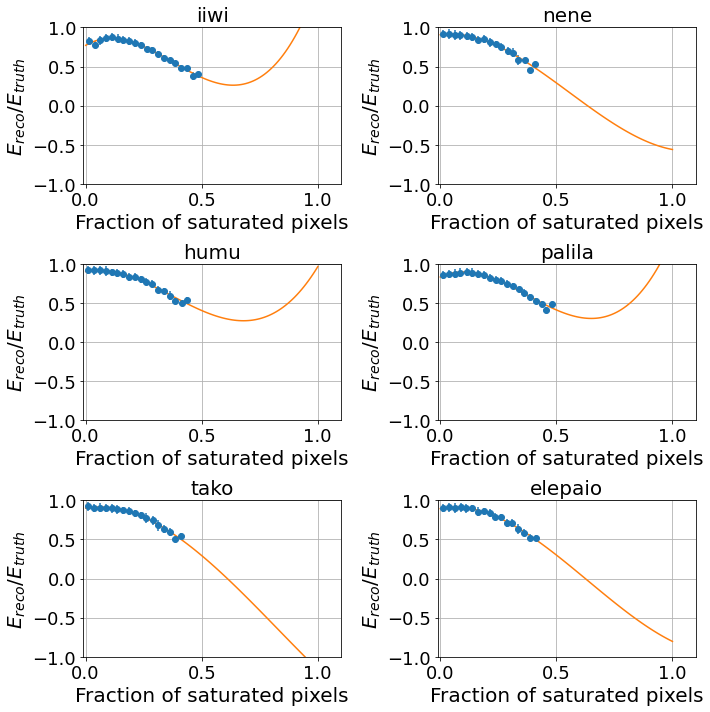

In [16]:
plt.figure(figsize = (10,10))
i = 1
fit = {}
means = {}
sems = {}
x = np.linspace(0,1,101)
for tpc in tpcs:
    plt.subplot(3,2,i)
    after_threshold_He[tpc]['reco_energy'] = after_threshold_He[tpc]['sumtot']*35.075/gain[tpc]*1e-3
    means[tpc] = sat_frac_group[tpc].mean().loc[sat_frac_group[tpc].sem()['reco_energy'].isna() == False]
    sems[tpc] = sat_frac_group[tpc].sem().loc[sat_frac_group[tpc].sem()['reco_energy'].isna() == False]
    plt.errorbar(means[tpc]['saturation_fraction'], 
                 means[tpc]['reco_energy']/means[tpc]['truth_energy'],
                 sems[tpc]['reco_energy']/means[tpc]['truth_energy'],
                 sems[tpc]['saturation_fraction'], 'o')
    fit[tpc] = np.polyfit(means[tpc]['saturation_fraction'], (means[tpc]['reco_energy']/means[tpc]['truth_energy']), 3)
    print(tpc, fit[tpc])
    plt.plot(x, fit[tpc][0]*x**3 + fit[tpc][1]*x**2 + fit[tpc][2]*x**1 + fit[tpc][3]*x**0)
    plt.xlabel('Fraction of saturated pixels')
    plt.ylabel(r'$E_{reco}/E_{truth}$')
    plt.title(tpc)
    plt.ylim(-1,1)
    plt.xlim(-0.01,1.1)
    plt.grid()
    i += 1
plt.tight_layout()
plt.show()

### Perform saturation correction

In [17]:
def perform_saturation_correction(dataframe, fit):
    def get_saturation_correction_factor(x, fit):
        return fit[0]*x**3 +fit[1]*x**2 + fit[2]*x**1 + fit[3]
    dataframe['saturation_corrected_energy'] = 1/get_saturation_correction_factor(dataframe['saturation_fraction'], fit)*dataframe['reco_energy']
    return dataframe
for tpc in tpcs:
    after_threshold_He[tpc] = perform_saturation_correction(after_threshold_He[tpc], fit[tpc])
    sat_frac_group[tpc] = after_threshold_He[tpc].groupby(pd.cut(after_threshold_He[tpc]['saturation_fraction'], bins = np.linspace(0.0,0.3,12)))
    mean_tot_group[tpc] = after_threshold_He[tpc].groupby(pd.cut(after_threshold_He[tpc]['mean_tot'], bins = np.linspace(0,9,10)))

### Group by truth energy again (including sat. corrected energy)

In [18]:
before_drift_He_group = {}
after_drift_He_group = {}
after_thresh_group = {}
for tpc in tpcs:
    before_drift_He_group[tpc] = before_drift_He[tpc].groupby(['truth_energy'])
    after_drift_He_group[tpc] = after_drift_He[tpc].groupby(['truth_energy'])
    after_thresh_group[tpc] = after_threshold_He[tpc].groupby(['truth_energy'])

## Plot reconstructed energy/truth energy distributions again

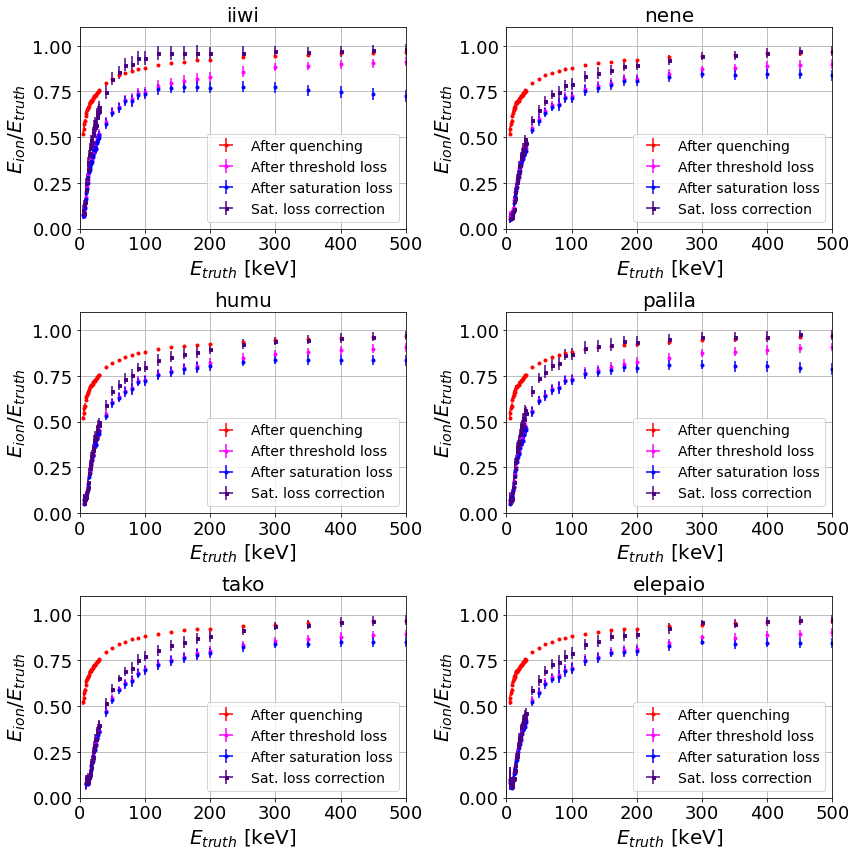

In [19]:
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
plt.figure(figsize = (12,12))
x_plt = np.linspace(-10,110,121)
sig = 1.96
i = 1
for tpc in tpcs:
    plt.subplot(3,2,i)
    plt.errorbar(after_drift_He_group[tpc].mean().index,
                 after_drift_He_group[tpc].mean()['truth_charge']*35.075*1e-03/after_drift_He_group[tpc].mean().index,
                 sig*after_drift_He_group[tpc].sem()['truth_charge']*35.075*1e-03/after_drift_He_group[tpc].mean().index,
                 [0 for i in range(0,len(after_drift_He_group[tpc].mean()))],
                 'o',markersize = 3, label = r'After quenching', color = 'red')
    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].mean()['qsum']*35.075*1e-03/gain[tpc])/after_thresh_group[tpc].mean().index,
                 sig*(after_thresh_group[tpc].sem()['qsum']*35.075*1e-03/gain[tpc])/after_thresh_group[tpc].mean().index,
                 [0 for i in range(0,len(after_thresh_group[tpc].mean()))],
                 'o',markersize = 3, label = r'After threshold loss', color = 'magenta')
    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].mean()['sumtot']*35.075*1e-03/gain[tpc])/after_thresh_group[tpc].mean().index,
                 sig*(after_thresh_group[tpc].sem()['sumtot']*35.075*1e-03/gain[tpc])/after_thresh_group[tpc].mean().index,
                 [0 for i in range(0,len(after_thresh_group[tpc].mean()))],
                 'o',markersize = 3, label = r'After saturation loss', color = 'blue')
    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].mean()['saturation_corrected_energy'])/after_thresh_group[tpc].mean().index,
                 sig*(after_thresh_group[tpc].sem()['saturation_corrected_energy'])/after_thresh_group[tpc].mean().index,
                 [0 for i in range(0,len(after_thresh_group[tpc].mean()))],
                's',markersize = 3, label = r'Sat. loss correction', color = 'indigo')
    plt.ylabel(r'$E_{ion}/E_{truth}$')
    plt.xlabel(r'$E_{truth}$ [keV]')
    plt.ylim(0,1.1)
    plt.xlim(0,500)
    plt.legend(loc ='lower right')
    plt.grid()
    plt.title(tpc)
    i += 1
plt.tight_layout()
plt.show()

### Add RMS errors for saturation correction

In [20]:
h_sat_cor = {}
vals_sat_cor = {}
rms_errors_sat_cor = {}

for tpc in tpcs:
    rms_errors_sat_cor[tpc] = []
    for energy in after_threshold_He[tpc]['truth_energy'].unique(): #sat_cor loop
        h_sat_cor[tpc+'_'+str(energy)] = ROOT.TH1F('%s_%s'%(tpc,energy), '%s_%s'%(tpc,energy), 21, 0, 100)
        vals_sat_cor[tpc+'_'+str(energy)] = array.array('d', after_thresh_group[tpc].mean().loc[after_threshold_He[tpc]['truth_energy'] == energy]['saturation_corrected_energy'])
        for i in range(0,len(vals_sat_cor[tpc+'_'+str(energy)])):
            h_sat_cor[tpc+'_'+str(energy)].Fill(vals_sat_cor[tpc+'_'+str(energy)][i])
        rms_errors_sat_cor[tpc].append(h_sat_cor[tpc+'_'+str(energy)].GetRMSError())
    rms_errors_sat_cor[tpc] = np.array(rms_errors_sat_cor[tpc])

Warning in <TROOT::Append>: Replacing existing TH1: iiwi_100.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_10.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_11.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_120.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_12.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_13.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_140.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_14.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_15.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_160.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_16.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing e

## Plot energy resolutions again

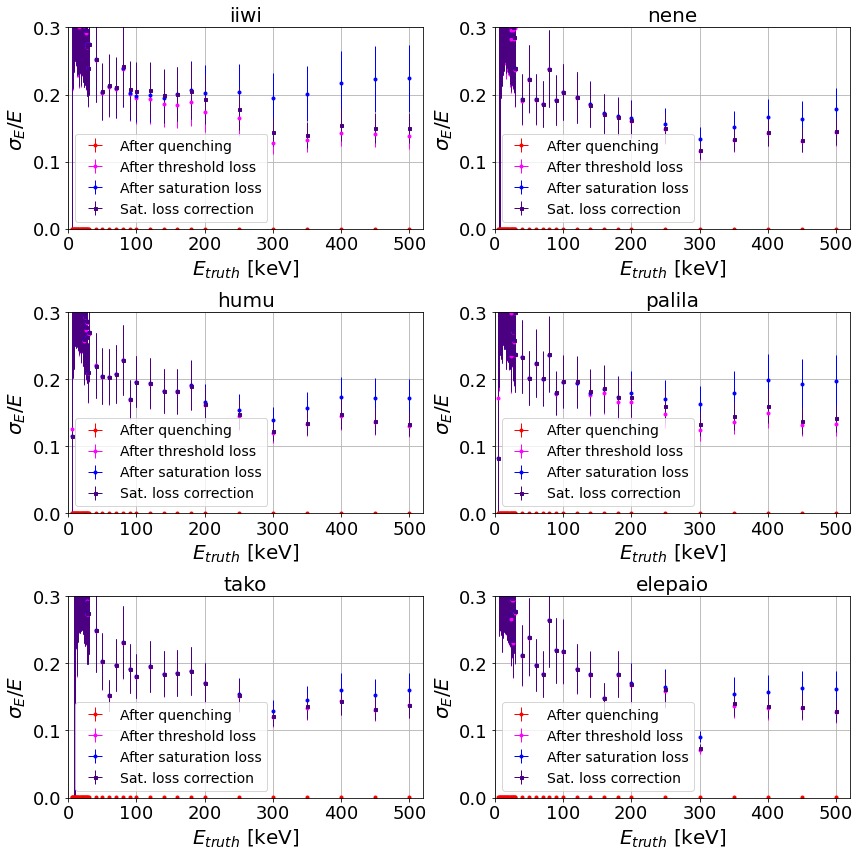

In [21]:
reso_errors_sat_cor = {}

for tpc in tpcs:
    reso_errors_sat_cor[tpc] = after_thresh_group[tpc].std()['saturation_corrected_energy']/after_thresh_group[tpc].mean()['saturation_corrected_energy'] * np.sqrt((rms_errors_sat_cor[tpc]/(after_thresh_group[tpc].std()['saturation_corrected_energy']))**2 + (after_thresh_group[tpc].std()['saturation_corrected_energy']/(after_thresh_group[tpc].mean()['saturation_corrected_energy']))**2)

plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
plt.figure(figsize = (12,12))
x_plt = np.linspace(-10,110,121)
i = 1
for tpc in tpcs:
    plt.subplot(3,2,i)
    plt.errorbar(after_drift_He_group[tpc].mean().index,
                 after_drift_He_group[tpc].std()['truth_charge']*35.075*1e-03/after_drift_He_group[tpc].mean()['truth_charge']*35.075*1e-03,
                 reso_errors_quench[tpc], [0 for i in range(0,len(reso_errors_quench[tpc]))],
                 'o',markersize = 3, label = r'After quenching', color = 'red', lw = 1)
    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].std()['qsum']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['qsum']*35.075*1e-03/gain[tpc]),
                 reso_errors_thresh[tpc], [0 for i in range(0,len(reso_errors_thresh[tpc]))],
                 'o',markersize = 3, label = r'After threshold loss', color = 'magenta', lw = 1)
    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].std()['sumtot']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['sumtot']*35.075*1e-03/gain[tpc]),
                 reso_errors_thresh_sat[tpc], [0 for i in range(0,len(reso_errors_thresh_sat[tpc]))],
                 'o',markersize = 3, label = r'After saturation loss', color = 'blue', lw = 1)
    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].std()['saturation_corrected_energy'])/(after_thresh_group[tpc].mean()['saturation_corrected_energy']),
                 reso_errors_sat_cor[tpc], [0 for i in range(0,len(reso_errors_sat_cor[tpc]))],
                's',markersize = 3, label = r'Sat. loss correction', color = 'indigo', lw = 1)
    plt.xlabel(r'$E_{truth}$ [keV]')
    plt.ylabel(r'$\sigma_E/E$')
    plt.xlim(0,520)
    plt.ylim(0,0.3)
    plt.title(tpc)
    plt.grid()
    plt.legend()
    i += 1
plt.tight_layout()
plt.show()

### Preliminary threshold corrections
We will truncate at mean_tot = 8, only correcting for recoils with mean_tot < 8

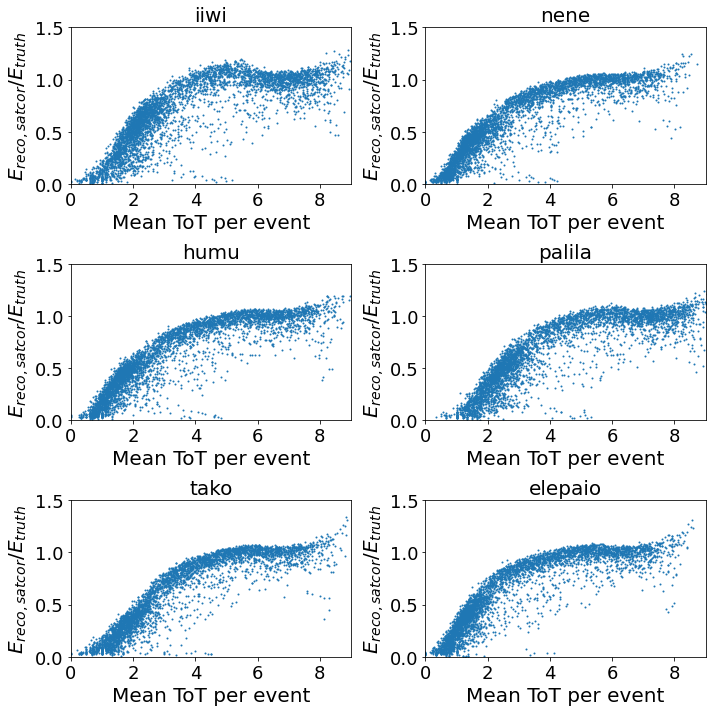

In [22]:
plt.figure(figsize = (10,10))
i = 1
fit_thresh = {}
x_thresh = np.linspace(0,13,101)
for tpc in tpcs:
    plt.subplot(3,2,i)
    plt.plot(after_threshold_He[tpc]['mean_tot'], after_threshold_He[tpc]['saturation_corrected_energy']/after_threshold_He[tpc]['truth_energy'],'o',markersize = 1)
    #fit_thresh[tpc] = np.polyfit(after_threshold_He[tpc]['mean_tot'], (after_threshold_He[tpc]['saturation_corrected_energy']/after_threshold_He[tpc]['truth_energy']), 5)
    #print(tpc, fit_thresh[tpc])
    #plt.plot(x_thresh, fit_thresh[tpc][0]*x_thresh**5 + fit_thresh[tpc][1]*x_thresh**4 + fit_thresh[tpc][2]*x_thresh**3 + fit_thresh[tpc][3]*x_thresh**2 + fit_thresh[tpc][4]*x_thresh**1 + fit_thresh[tpc][5]*x_thresh**0)
    plt.xlabel('Mean ToT per event')
    plt.ylabel(r'$E_{reco,sat cor}/E_{truth}$')
    plt.xlim(0,9)
    plt.ylim(0,1.5)
    plt.title(tpc)
    i += 1
plt.tight_layout()
plt.show()

In [23]:
mean_tot_group = {}
for tpc in tpcs:
    mean_tot_group[tpc] = after_threshold_He[tpc].groupby(pd.cut(after_threshold_He[tpc]['mean_tot'], bins = np.linspace(0,8,26)))

iiwi [-0.00041427  0.00965952 -0.08154091  0.27105124 -0.07932348  0.0219775 ]
nene [-5.29108207e-05  1.14780465e-03 -9.21626800e-03  7.84713589e-03
  2.81621313e-01 -5.20635175e-02]
humu [-9.00278878e-05  2.14295483e-03 -1.84390848e-02  4.62812014e-02
  2.11814168e-01 -4.49254638e-02]
palila [-0.00060192  0.01395287 -0.12078162  0.45231321 -0.47040598  0.18842536]
tako [-6.37429721e-05  2.98691590e-03 -3.99215982e-02  1.87274090e-01
 -9.02878044e-02  4.93982896e-02]
elepaio [-0.00043621  0.00957266 -0.07436241  0.21081124  0.07522079  0.00874963]


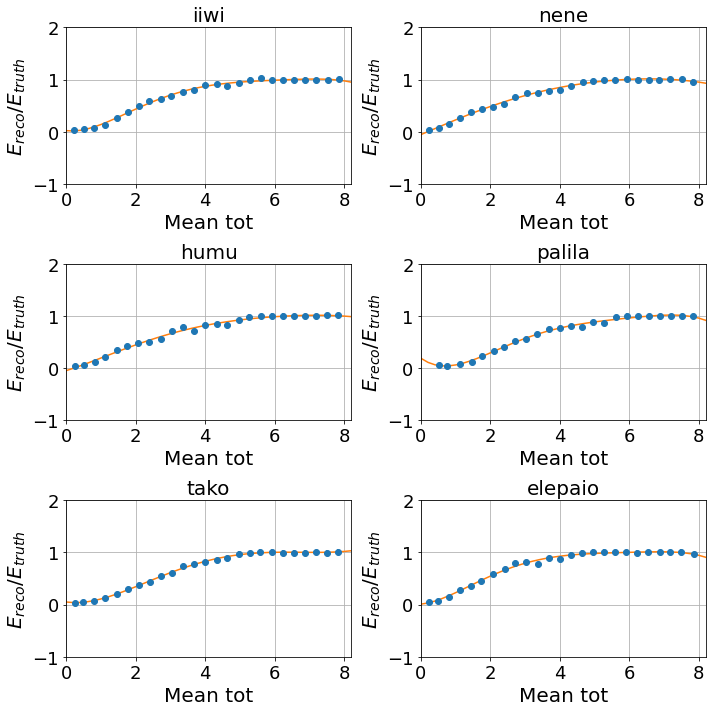

In [24]:
def plot_fit(x, fit):
    func = 0
    for i in range(0,len(fit)):
        func += fit[i]*x**(len(fit)-i-1)
    plt.plot(x,func)

plt.figure(figsize = (10,10))
i = 1
fit_thresh = {}
means_thresh = {}
sems_thresh = {}
x_thresh = np.linspace(0,20,101)
for tpc in tpcs:
    plt.subplot(3,2,i)
    means_thresh[tpc] = mean_tot_group[tpc].mean().loc[mean_tot_group[tpc].sem()['saturation_corrected_energy'].isna() == False]
    sems_thresh[tpc] = mean_tot_group[tpc].sem().loc[mean_tot_group[tpc].sem()['saturation_corrected_energy'].isna() == False]
    plt.errorbar(means_thresh[tpc]['mean_tot'], 
                 means_thresh[tpc]['saturation_corrected_energy']/means_thresh[tpc]['truth_energy'],
                 sems_thresh[tpc]['saturation_corrected_energy']/means_thresh[tpc]['truth_energy'],
                 sems_thresh[tpc]['mean_tot'], 'o')
    fit_thresh[tpc] = np.polyfit(means_thresh[tpc]['mean_tot'], (means_thresh[tpc]['saturation_corrected_energy']/means_thresh[tpc]['truth_energy']), 5)
    print(tpc, fit_thresh[tpc])
    plot_fit(x_thresh, fit_thresh[tpc])
    plt.xlabel('Mean tot')
    plt.ylabel(r'$E_{reco}/E_{truth}$')
    plt.title(tpc)
    plt.ylim(-1,2)
    plt.xlim(-0.01,8.2)
    plt.grid()
    i += 1
plt.tight_layout()
plt.show()

In [29]:
def perform_threshold_correction(dataframe, fit):
    def get_threshold_correction_factor(x, fit):
        return fit[0]*x**5 + fit[1]*x**4 + fit[2]*x**3 + fit[3]*x**2 + fit[4]*x**1 + fit[5]*x**0
    dataframe['full_corrected_energy'] = 1/get_threshold_correction_factor(dataframe['mean_tot'], fit)*dataframe['saturation_corrected_energy']
    index = dataframe.loc[dataframe['mean_tot']>8].index.to_numpy()
    dataframe['full_corrected_energy'][index] = dataframe['saturation_corrected_energy'][index] #truncate full correction range
    return dataframe

for tpc in tpcs:
    after_threshold_He[tpc] = perform_threshold_correction(after_threshold_He[tpc], fit_thresh[tpc])
    sat_frac_group[tpc] = after_threshold_He[tpc].groupby(pd.cut(after_threshold_He[tpc]['saturation_fraction'], bins = np.linspace(0.0,0.3,12)))
    mean_tot_group[tpc] = after_threshold_He[tpc].groupby(pd.cut(after_threshold_He[tpc]['mean_tot'], bins = np.linspace(0,10,31)))


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

### Group dataframes with new full corrected energy branch by truth energy

In [30]:
before_drift_He_group = {}
after_drift_He_group = {}
after_thresh_group = {}
for tpc in tpcs:
    before_drift_He_group[tpc] = before_drift_He[tpc].groupby(['truth_energy'])
    after_drift_He_group[tpc] = after_drift_He[tpc].groupby(['truth_energy'])
    after_thresh_group[tpc] = after_threshold_He[tpc].groupby(['truth_energy'])

### Final plots of reconstructed over truth energy vs truth energy

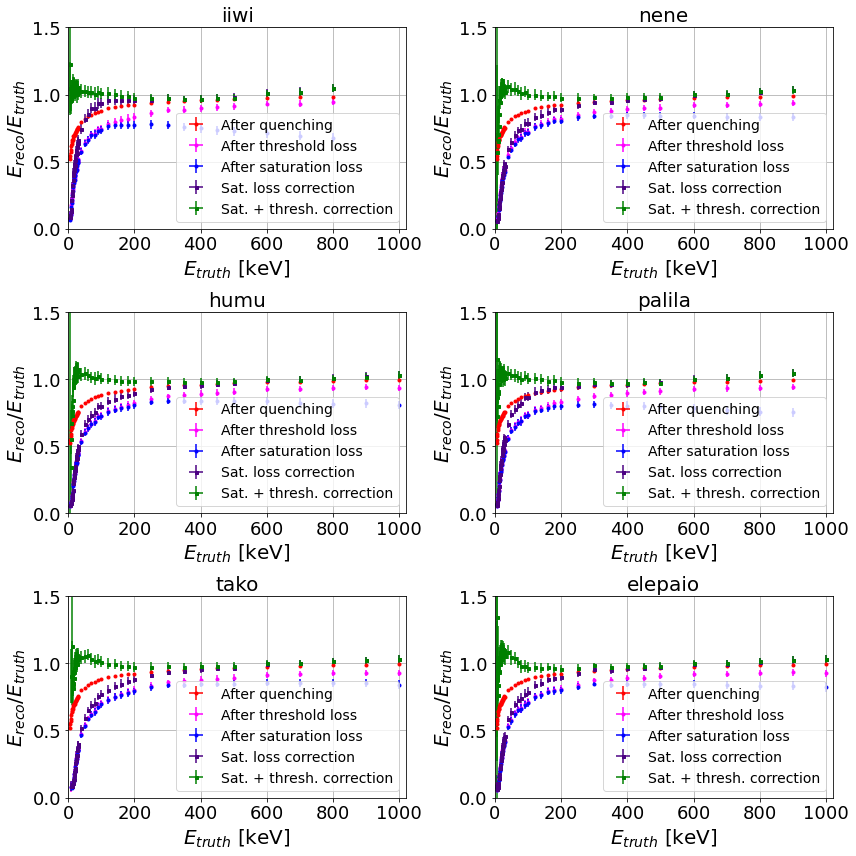

In [31]:
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
plt.figure(figsize = (12,12))
x_plt = np.linspace(-10,110,121)
sig = 1.96
i = 1
for tpc in tpcs:
    plt.subplot(3,2,i)
    plt.errorbar(after_drift_He_group[tpc].mean().index,
                 after_drift_He_group[tpc].mean()['truth_charge']*35.075*1e-03/after_drift_He_group[tpc].mean().index,
                 sig*after_drift_He_group[tpc].sem()['truth_charge']*35.075*1e-03/after_drift_He_group[tpc].mean().index,
                 [0 for i in range(0,len(after_drift_He_group[tpc].mean()))],
                 'o',markersize = 3, label = r'After quenching', color = 'red')
    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].mean()['qsum']*35.075*1e-03/gain[tpc])/after_thresh_group[tpc].mean().index,
                 sig*(after_thresh_group[tpc].sem()['qsum']*35.075*1e-03/gain[tpc])/after_thresh_group[tpc].mean().index,
                 [0 for i in range(0,len(after_thresh_group[tpc].mean()))],
                 'o',markersize = 3, label = r'After threshold loss', color = 'magenta')
    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].mean()['sumtot']*35.075*1e-03/gain[tpc])/after_thresh_group[tpc].mean().index,
                 sig*(after_thresh_group[tpc].sem()['sumtot']*35.075*1e-03/gain[tpc])/after_thresh_group[tpc].mean().index,
                 [0 for i in range(0,len(after_thresh_group[tpc].mean()))],
                 'o',markersize = 3, label = r'After saturation loss', color = 'blue')
    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].mean()['saturation_corrected_energy'])/after_thresh_group[tpc].mean().index,
                 sig*(after_thresh_group[tpc].sem()['saturation_corrected_energy'])/after_thresh_group[tpc].mean().index,
                 [0 for i in range(0,len(after_thresh_group[tpc].mean()))],
                's',markersize = 3, label = r'Sat. loss correction', color = 'indigo')
    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].mean()['full_corrected_energy'])/after_thresh_group[tpc].mean().index,
                 sig*(after_thresh_group[tpc].sem()['full_corrected_energy'])/after_thresh_group[tpc].mean().index,
                 [0 for i in range(0,len(after_thresh_group[tpc].mean()))],
                's',markersize = 3, label = r'Sat. + thresh. correction', color = 'green')
    plt.ylabel(r'$E_{reco}/E_{truth}$')
    plt.xlabel(r'$E_{truth}$ [keV]')
    plt.ylim(0,1.5)
    plt.xlim(0,1020)
    plt.legend(loc ='lower right')
    plt.grid()
    plt.title(tpc)
    i += 1
plt.tight_layout()
plt.show()

### Add RMS errors for full correction

In [32]:
h_full_cor = {}
vals_full_cor = {}
rms_errors_full_cor = {}

for tpc in tpcs:
    rms_errors_full_cor[tpc] = []
    for energy in after_threshold_He[tpc]['truth_energy'].unique(): #full_cor loop
        h_full_cor[tpc+'_'+str(energy)] = ROOT.TH1F('%s_%s'%(tpc,energy), '%s_%s'%(tpc,energy), 21, 0, 100)
        vals_full_cor[tpc+'_'+str(energy)] = array.array('d', after_thresh_group[tpc].mean().loc[after_threshold_He[tpc]['truth_energy'] == energy]['full_corrected_energy'])
        for i in range(0,len(vals_full_cor[tpc+'_'+str(energy)])):
            h_full_cor[tpc+'_'+str(energy)].Fill(vals_full_cor[tpc+'_'+str(energy)][i])
        rms_errors_full_cor[tpc].append(h_full_cor[tpc+'_'+str(energy)].GetRMSError())
    rms_errors_full_cor[tpc] = np.array(rms_errors_full_cor[tpc])

Warning in <TROOT::Append>: Replacing existing TH1: iiwi_100.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_10.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_11.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_120.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_12.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_13.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_140.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_14.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_15.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_160.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: iiwi_16.0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing e

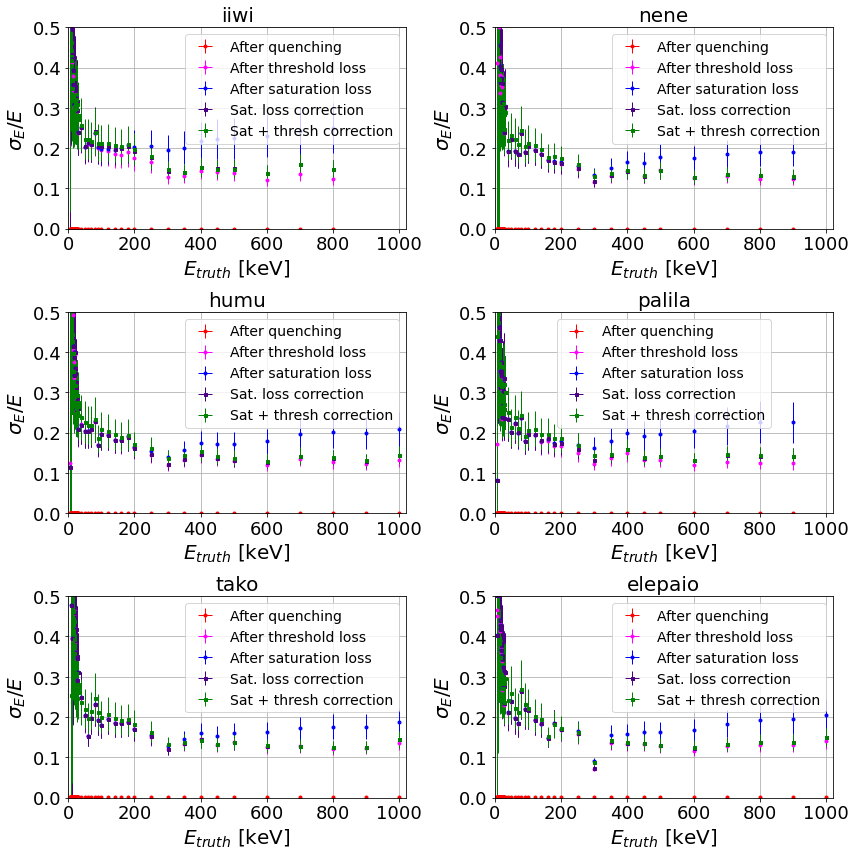

In [33]:
reso_errors_full_cor = {}

for tpc in tpcs:
    reso_errors_full_cor[tpc] = after_thresh_group[tpc].std()['full_corrected_energy']/after_thresh_group[tpc].mean()['full_corrected_energy'] * np.sqrt((rms_errors_sat_cor[tpc]/(after_thresh_group[tpc].std()['full_corrected_energy']))**2 + (after_thresh_group[tpc].std()['full_corrected_energy']/(after_thresh_group[tpc].mean()['full_corrected_energy']))**2)

plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
plt.figure(figsize = (12,12))
x_plt = np.linspace(-10,110,121)
i = 1
for tpc in tpcs:
    plt.subplot(3,2,i)
    plt.errorbar(after_drift_He_group[tpc].mean().index,
                 after_drift_He_group[tpc].std()['truth_charge']*35.075*1e-03/after_drift_He_group[tpc].mean()['truth_charge']*35.075*1e-03,
                 reso_errors_quench[tpc], [0 for i in range(0,len(reso_errors_quench[tpc]))],
                 'o',markersize = 3, label = r'After quenching', color = 'red', lw = 1)
    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].std()['qsum']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['qsum']*35.075*1e-03/gain[tpc]),
                 reso_errors_thresh[tpc], [0 for i in range(0,len(reso_errors_thresh[tpc]))],
                 'o',markersize = 3, label = r'After threshold loss', color = 'magenta', lw = 1)
    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].std()['sumtot']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['sumtot']*35.075*1e-03/gain[tpc]),
                 reso_errors_thresh_sat[tpc], [0 for i in range(0,len(reso_errors_thresh_sat[tpc]))],
                 'o',markersize = 3, label = r'After saturation loss', color = 'blue', lw = 1)
    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].std()['saturation_corrected_energy'])/(after_thresh_group[tpc].mean()['saturation_corrected_energy']),
                 reso_errors_sat_cor[tpc], [0 for i in range(0,len(reso_errors_sat_cor[tpc]))],
                's',markersize = 3, label = r'Sat. loss correction', color = 'indigo', lw = 1)
    plt.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].std()['full_corrected_energy'])/(after_thresh_group[tpc].mean()['full_corrected_energy']),
                 reso_errors_full_cor[tpc], [0 for i in range(0,len(reso_errors_full_cor[tpc]))],
                's',markersize = 3, label = r'Sat + thresh correction', color = 'green', lw = 1)
    plt.xlabel(r'$E_{truth}$ [keV]')
    plt.ylabel(r'$\sigma_E/E$')
    plt.xlim(0,1020)
    plt.ylim(0,0.5)
    plt.title(tpc)
    plt.grid()
    plt.legend()
    i += 1
plt.tight_layout()
plt.show()